## Evaluation

This script will evaluate extensively which MRI modalities add the most value for glioma classification with XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator
from collections import Counter
import ast

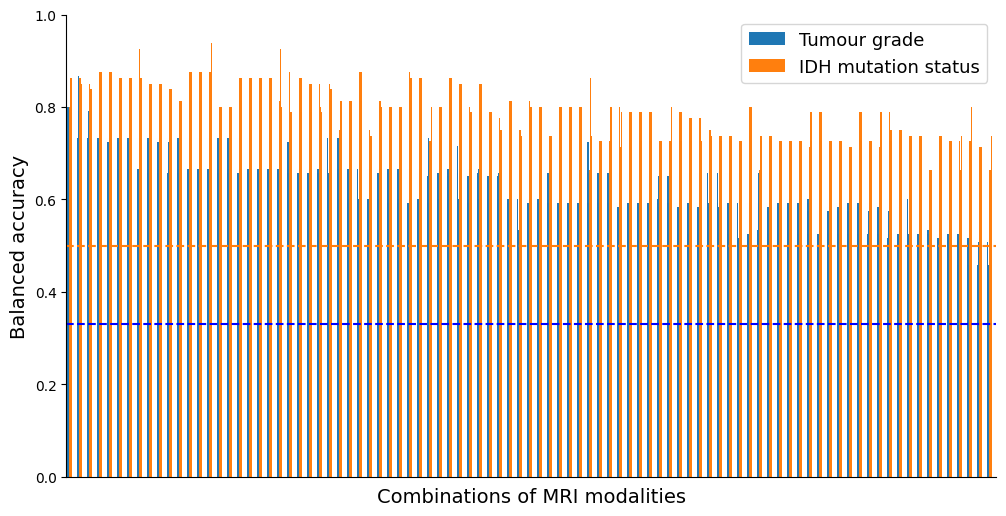

In [16]:
fontsize=14

def visualize_comparison(results_df, ROI):
    # Select only columns with '_balanced-accuracy' in their names
    performance_columns = [col for col in results_df.columns if 'balanced-accuracy' in col]
    results_df = results_df[['Acquisition'] + performance_columns]
    
    # Plot the data
    ax = results_df.plot.bar(rot=0, figsize=(12, 6), x='Acquisition')
    plt.ylim(0, 1)
    plt.ylabel("Balanced accuracy", fontsize=fontsize)
    plt.xlabel("Combinations of MRI modalities", fontsize=fontsize)
    
    # Update legend with new fontsize
    ax.legend(["Tumour grade", "IDH mutation status"], fontsize=fontsize-1)
    
    # Add horizontal lines with colors matching the matplotlib default colors
    plt.axhline(y=0.33, color='blue', linestyle='--')
    plt.axhline(y=0.5, color='tab:orange', linestyle='--')
    
    # Turn off the x-axis ticks and labels
    ax.axes.get_xaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the figure
    fig = ax.get_figure()
    fig.savefig(f"/Users/Gabriel/Desktop/bestOverall{ROI}.png", dpi=300)

# Import data 
ROI = 'whole_tumour'
results_df = pd.read_csv('/Users/Gabriel/MSc_Dissertation/pyRadiomics/Model_performance/' + ROI + '_XGBoost_evaluation.csv')

# Create a new column 'sum'
results_df['sum'] = results_df['WHO CNS Grade balanced-accuracy'] + results_df['IDH balanced-accuracy']

# Sort the dataframe by 'sum' from highest to lowest
results_df = results_df.sort_values('sum', ascending=False)

# Call the function with the new fontsize parameter
visualize_comparison(results_df, ROI)


### Table: Best modalities for overall prediction

In [2]:
# Import data 
ROI = ['roi1', 'roi4', 'roi2', 'whole_tumour', 'brain']
ROI_names = ['Necrotic core', 'Enhancing region', 'Non-enhancing region', 'Whole tumour', 'Brain']

dataframes = {}
for roi in ROI:
    df = pd.read_csv(f'/Users/Gabriel/MSc_Dissertation/pyRadiomics/Model_performance/{roi}_XGBoost_evaluation.csv')
    df['sum'] = (df['WHO CNS Grade balanced-accuracy'] + df['IDH balanced-accuracy'])/2
    dataframes[roi] = df

# Create a mapping from the original names to the new names
name_mapping = dict(zip(ROI, ROI_names))

# Calculate mean of 'sum' column for each DataFrame
average_sums = {name_mapping[roi]: df['sum'].mean() for roi, df in dataframes.items()}

# Calculate standard error of 'sum' column for each DataFrame
standard_errors = {name_mapping[roi]: df['sum'].std() / np.sqrt(len(df)) for roi, df in dataframes.items()}

# Print standard errors
for roi_name, standard_error in standard_errors.items():
    print(f"The standard error for {roi_name} is {standard_error}")


pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
largest = dataframes['whole_tumour'].nlargest(3, 'IDH balanced-accuracy')
smallest = dataframes['whole_tumour'].nsmallest(3, 'IDH balanced-accuracy')

df_sorted_all = dataframes['whole_tumour'].sort_values(by='sum', ascending=False)

largest


The standard error for Necrotic core is 0.0020606496201600196
The standard error for Enhancing region is 0.003476862240005624
The standard error for Non-enhancing region is 0.0013097321299491752
The standard error for Whole tumour is 0.0017557206453119967
The standard error for Brain is 0.0010636394548823337


,Acquisition,WHO CNS Grade balanced-accuracy,IDH balanced-accuracy,sum
231,"('ADC', 'SWI', 'T1_contrast', 'T1')",0.666667,0.9375,0.802083
253,"('ADC', 'T1_contrast', 'ASL', 'T2')",0.600000,0.9375,0.768750
490,"('ADC', 'SWI', 'T1_contrast', 'ASL', 'T2')",0.600000,0.9375,0.768750


/Users/Gabriel/opt/anaconda3/envs/py3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


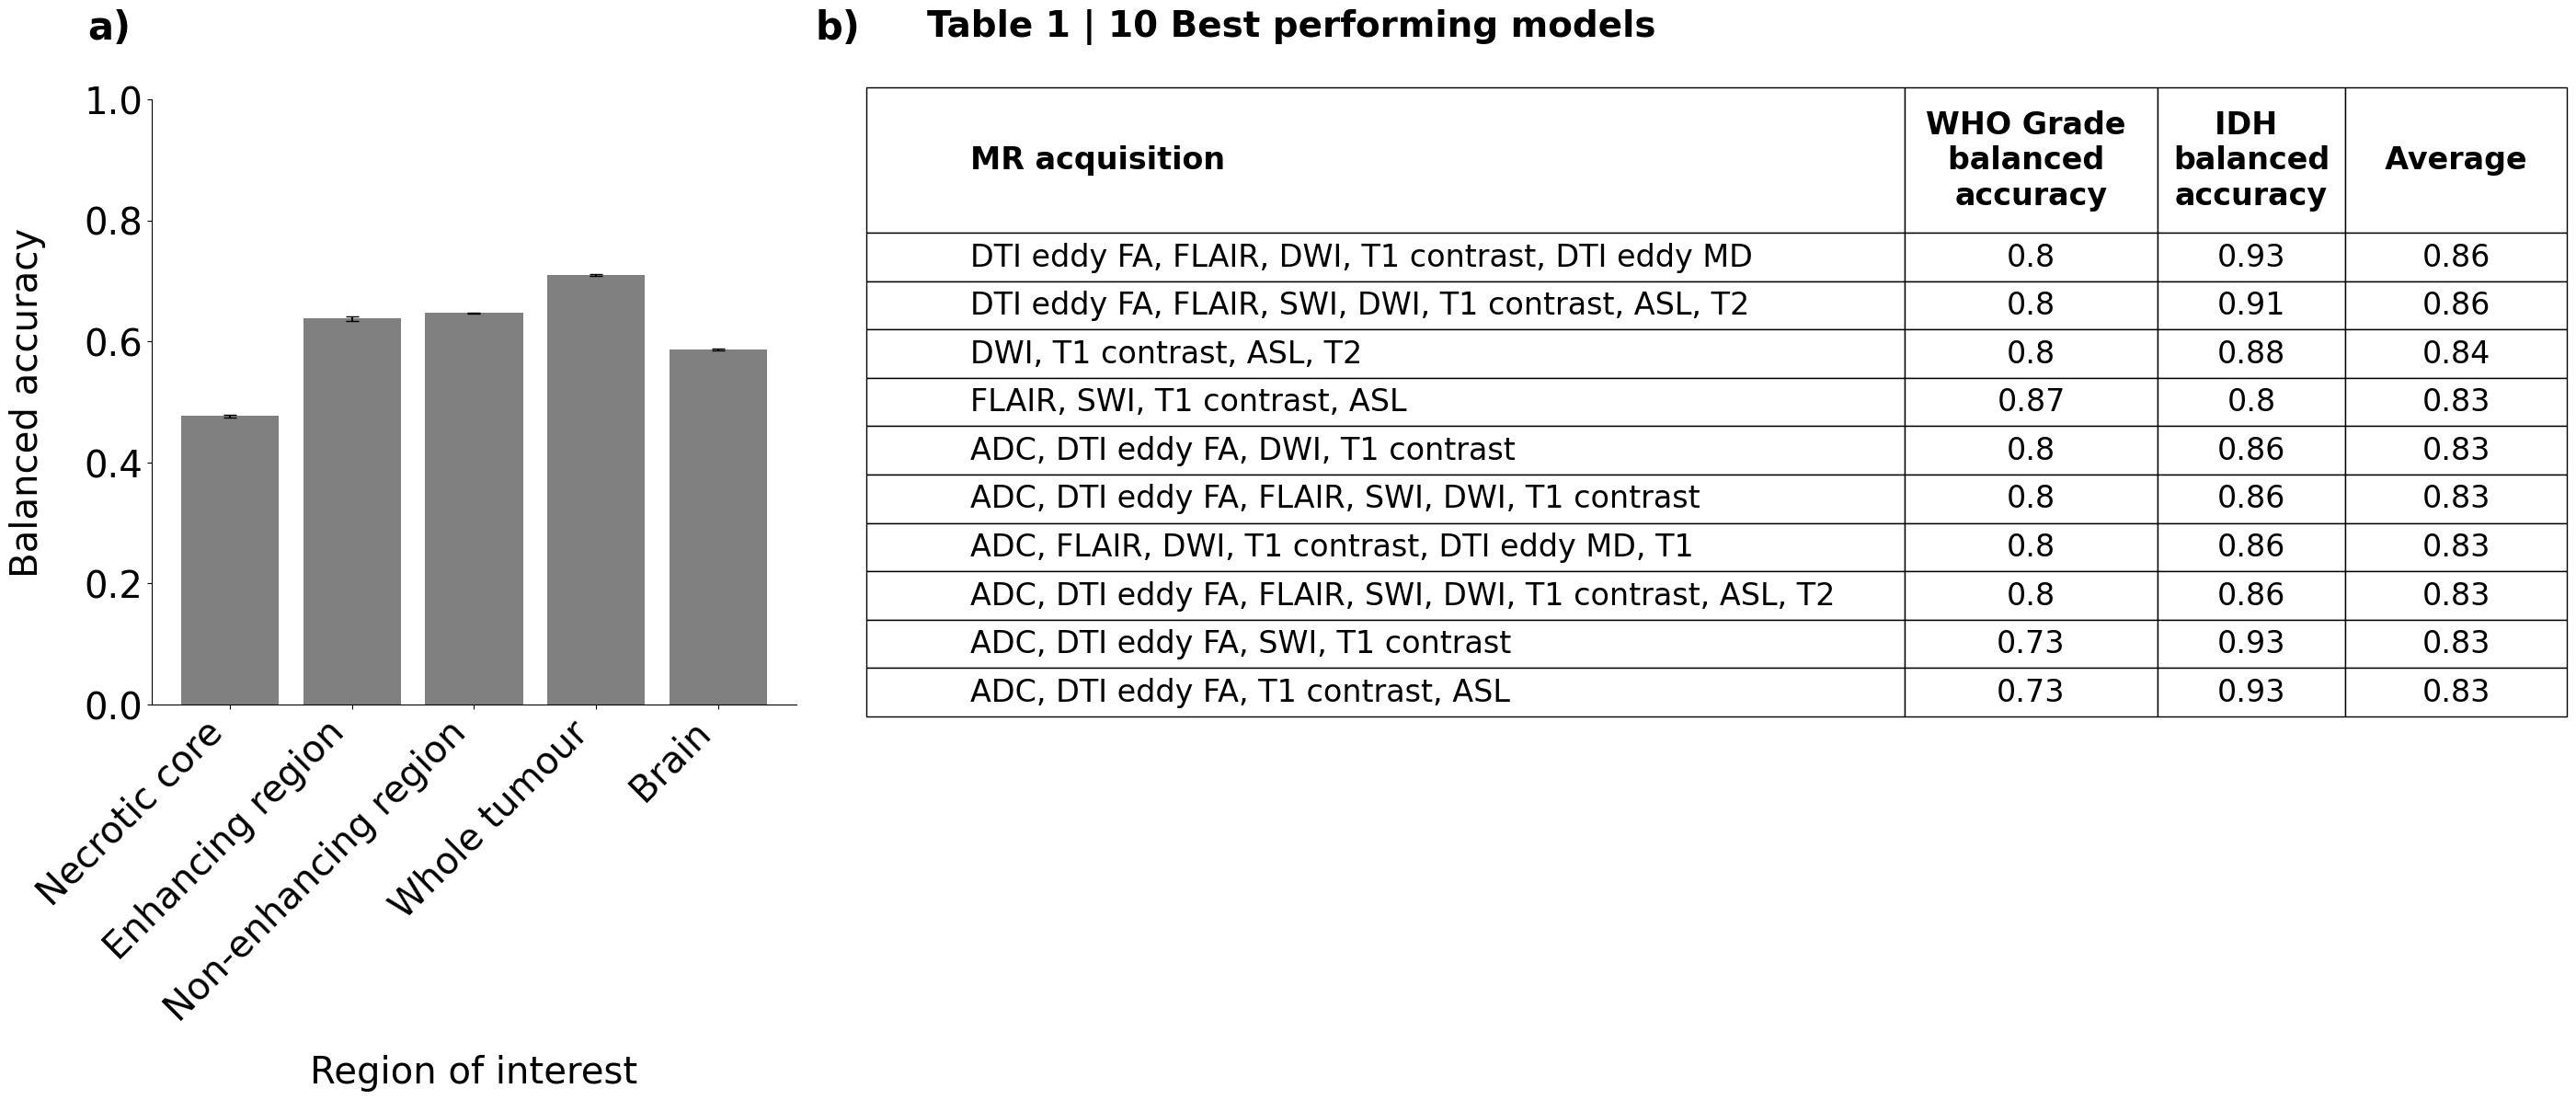

In [41]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fontsize = 24
fontsize_bar = 29
ABsize = 30

# Increase default font size
plt.rcParams.update({'font.size': fontsize})

# Create a figure with two subplots, one of which is twice as wide as the other
fig = plt.figure(figsize=(30, 13))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 0.1])  # Here, you create 3 subplots, the second one is twice as wide as the first one, and the last one is left empty to act as a spacer.

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Bar Plot
ax1.bar(average_sums.keys(), average_sums.values(), color='grey', yerr=[standard_errors[key] for key in average_sums.keys()],capsize=5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Region of interest', labelpad = 20, fontsize=fontsize_bar)  # Increase the size of the x-axis label
ax1.set_ylabel('Balanced accuracy', labelpad = 30, fontsize=fontsize_bar)  # Increase the size of the y-axis label
ax1.set_ylim(0,1)
ax1.set_yticks(np.arange(0, 1.2, 0.2))  # Set y-axis ticks

# Increase the size of the tick labels
ax1.tick_params(axis='x', labelsize=fontsize_bar, rotation=45)  # Increase the size of the x-axis tick labels and rotate them
ax1.set_xticklabels(average_sums.keys(), rotation=45, ha = 'right') # Rotate x-axis labels
ax1.tick_params(axis='y', labelsize=fontsize_bar)  # Increase the size of the y-axis tick labels

ax1.text(-0.1, 1.1, 'a)', transform=ax1.transAxes, size=ABsize, weight='bold')

# Table of best modalities
# Your dataframe
df_to_save = dataframes['whole_tumour'].nlargest(10, 'sum')

# Round to 2 decimal places
df_to_save = df_to_save.round(2)

# Remove parentheses and single quotes from the 'Acquisition' column
df_to_save['Acquisition'] = df_to_save['Acquisition'].str.replace(r"[()']", '')
df_to_save['Acquisition'] = df_to_save['Acquisition'].str.replace(r"[_]", ' ')

# Rename 'WHO CNS Grade balanced-accuracy' column
df_to_save = df_to_save.rename(columns={'WHO CNS Grade balanced-accuracy': 'WHO Grade \nbalanced \naccuracy'})
df_to_save = df_to_save.rename(columns={'IDH balanced-accuracy': 'IDH \nbalanced\naccuracy'})
df_to_save = df_to_save.rename(columns={'sum': '  Average  '})
df_to_save = df_to_save.rename(columns={'Acquisition': 'MR acquisition'})

# Hide axes for table
ax2.axis('off')

# Make a table and add it to the figure
table = ax2.table(cellText=df_to_save.values, 
                  colLabels=df_to_save.columns, 
                  cellLoc = 'left', 
                  loc='center')

# Loop through each cell in the table and modify its alignment
for i in range(len(df_to_save.columns)):
    for j in range(len(df_to_save)+1):  # +1 to account for the header row
        cell = table[j, i]
        if i == 0:
            cell.set_text_props(ha='left')
        else:
            cell.set_text_props(ha='center')

# Increase the width of the cells of the first column
table.auto_set_column_width(col=list(range(len(df_to_save.columns))))
table[0, 0].set_width(2*table[0, 0].get_width())

table.auto_set_font_size(False)
table.set_fontsize(fontsize)

# Make the headers bold
for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_fontsize(10)
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

# Increase the height of the header row only
for i in range(len(df_to_save.columns)):
    cell = table[0, i]
    cell.set_height(3*cell.get_height())
    
for (row, col), cell in table.get_celld().items():
    cell.set_height(1.2*cell.get_height())

table.scale(4.0, 4.0)

ax2.text(-0.2, 1.1, 'b)', transform=ax2.transAxes, size=ABsize, weight='bold')
# Add table title
ax2.text(0.17, 1.15, 'Table 1 | 10 Best performing models', fontsize=fontsize+4, weight='bold', ha='center', va='top', transform=ax2.transAxes)


plt.tight_layout()
plt.savefig('/Users/Gabriel/Desktop/Figure_larger2.png', dpi=300)
plt.show()


## Frequency of Modalities at top 10

In [4]:
# Assuming df_sorted_all is your DataFrame and already sorted
top_10 = df_sorted_all.nlargest(10, 'sum')

# Convert string to tuple and flatten the list of acquisitions
all_acquisitions = [acquisition for sublist in top_10['Acquisition'].apply(ast.literal_eval) for acquisition in sublist]

# Count the frequency of each acquisition
counter = Counter(all_acquisitions)

# Sort by frequency in descending order and print out
for acquisition, freq in counter.most_common():
    print(f"{acquisition}: {freq}")

T1_contrast: 10
DWI: 8
DTI_eddy_FA: 6
FLAIR: 6
SWI: 6
ADC: 6
ASL: 5
T2: 3
DTI_eddy_MD: 2
T1: 1


## Distribution of top Modalities across performances

                                                            Acquisition  \
526       ('DTI_eddy_FA', 'FLAIR', 'DWI', 'T1_contrast', 'DTI_eddy_MD')   
935  ('DTI_eddy_FA', 'FLAIR', 'SWI', 'DWI', 'T1_contrast', 'ASL', 'T2')   
374                                 ('DWI', 'T1_contrast', 'ASL', 'T2')   
321                              ('FLAIR', 'SWI', 'T1_contrast', 'ASL')   
637        ('ADC', 'DTI_eddy_FA', 'FLAIR', 'SWI', 'DWI', 'T1_contrast')   

     WHO CNS Grade balanced-accuracy  IDH balanced-accuracy       sum  bin  
526                         0.800000               0.925305  0.862652    7  
935                         0.800000               0.913110  0.856555    7  
374                         0.800000               0.875000  0.837500    7  
321                         0.866667               0.800305  0.833486    7  
637                         0.800000               0.862805  0.831402    7  


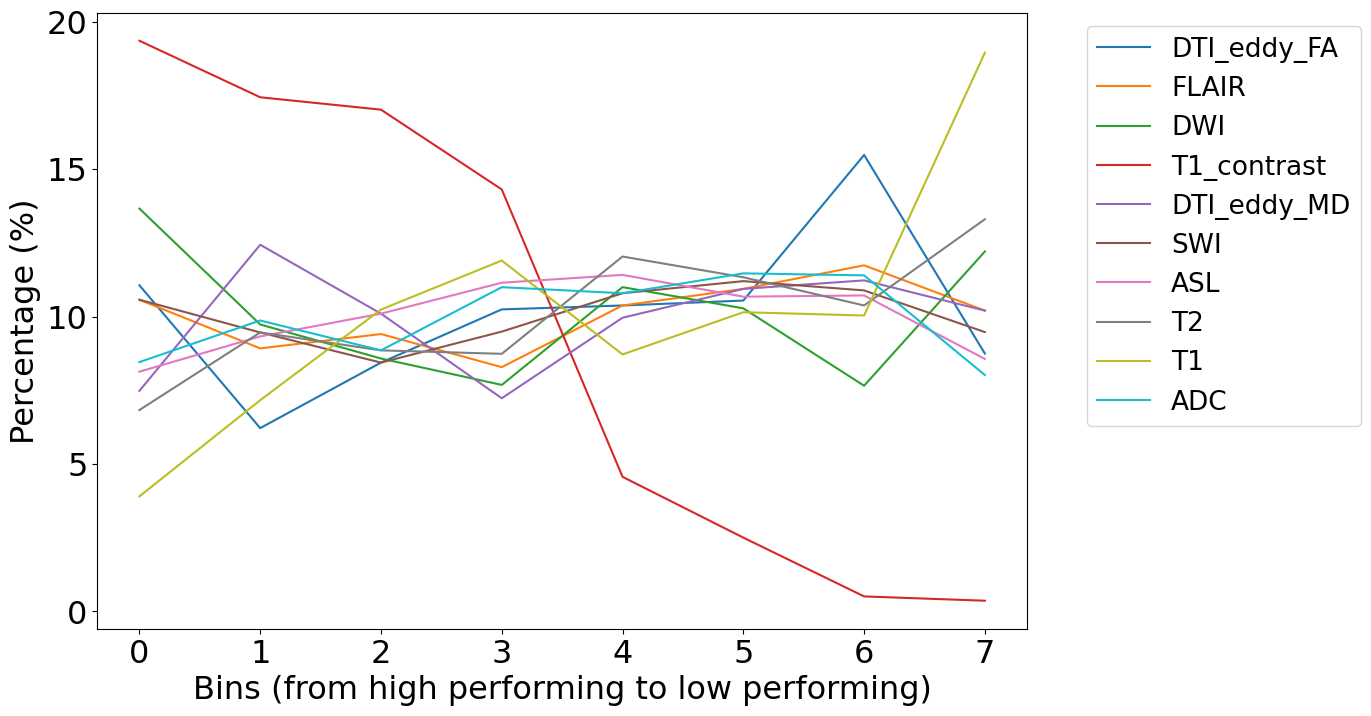

In [6]:
# Define the number of bins
num_bins = 8
fontsize= 23

print(df_sorted_all.head())

# Create bins based on 'sum' column
df_sorted_all['bin'] = pd.qcut(df_sorted_all['sum'], q=num_bins, labels=False, duplicates='drop')

# Initialize an empty dictionary to store the results
results = {}

# Iterate over each bin
for bin_num in range(num_bins):
    # Get rows corresponding to the current bin
    bin_rows = df_sorted_all[df_sorted_all['bin'] == bin_num]

    # Convert string to tuple and flatten the list of acquisitions
    all_acquisitions = [acquisition for sublist in bin_rows['Acquisition'].apply(ast.literal_eval) for acquisition in sublist]

    # Count the frequency of each acquisition
    counter = Counter(all_acquisitions)

    # Store the counter in the results dictionary
    results[bin_num] = counter

# List of all modalities
all_modalities = ['DTI_eddy_FA', 'FLAIR', 'DWI', 'T1_contrast', 'DTI_eddy_MD', 'SWI', 'ASL', 'T2', 'T1','ADC']

# Initialize a dictionary to hold counts for each modality and for the average
modality_counts = {modality: [] for modality in all_modalities}
average_acquisitions = []

# Populate the counts from the results dictionary
for bin_num in range(num_bins-1, -1, -1):  # iterating in reverse order
    # Skip the bin if there are no entries in it
    if len(results[bin_num]) == 0:
        continue

    # Count the total acquisitions
    total_acquisitions = sum(results[bin_num].values())
    
    # Count each modality and compute its percentage
    for modality in all_modalities:
        modality_counts[modality].append((results[bin_num][modality] / total_acquisitions) * 100)

# Plotting
plt.figure(figsize=(12,8))
for modality, counts in modality_counts.items():
    plt.plot(range(len(counts)), counts, label=modality)
    

# set font size
plt.rcParams.update({'font.size': fontsize})

# set the legend outside to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = fontsize - 4)

plt.xlabel('Bins (from high performing to low performing)',fontsize=fontsize)
plt.ylabel('Percentage (%)',fontsize=fontsize)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.savefig('/Users/Gabriel/Desktop/modalities_importance.png', dpi = 300,bbox_inches='tight')
plt.show()

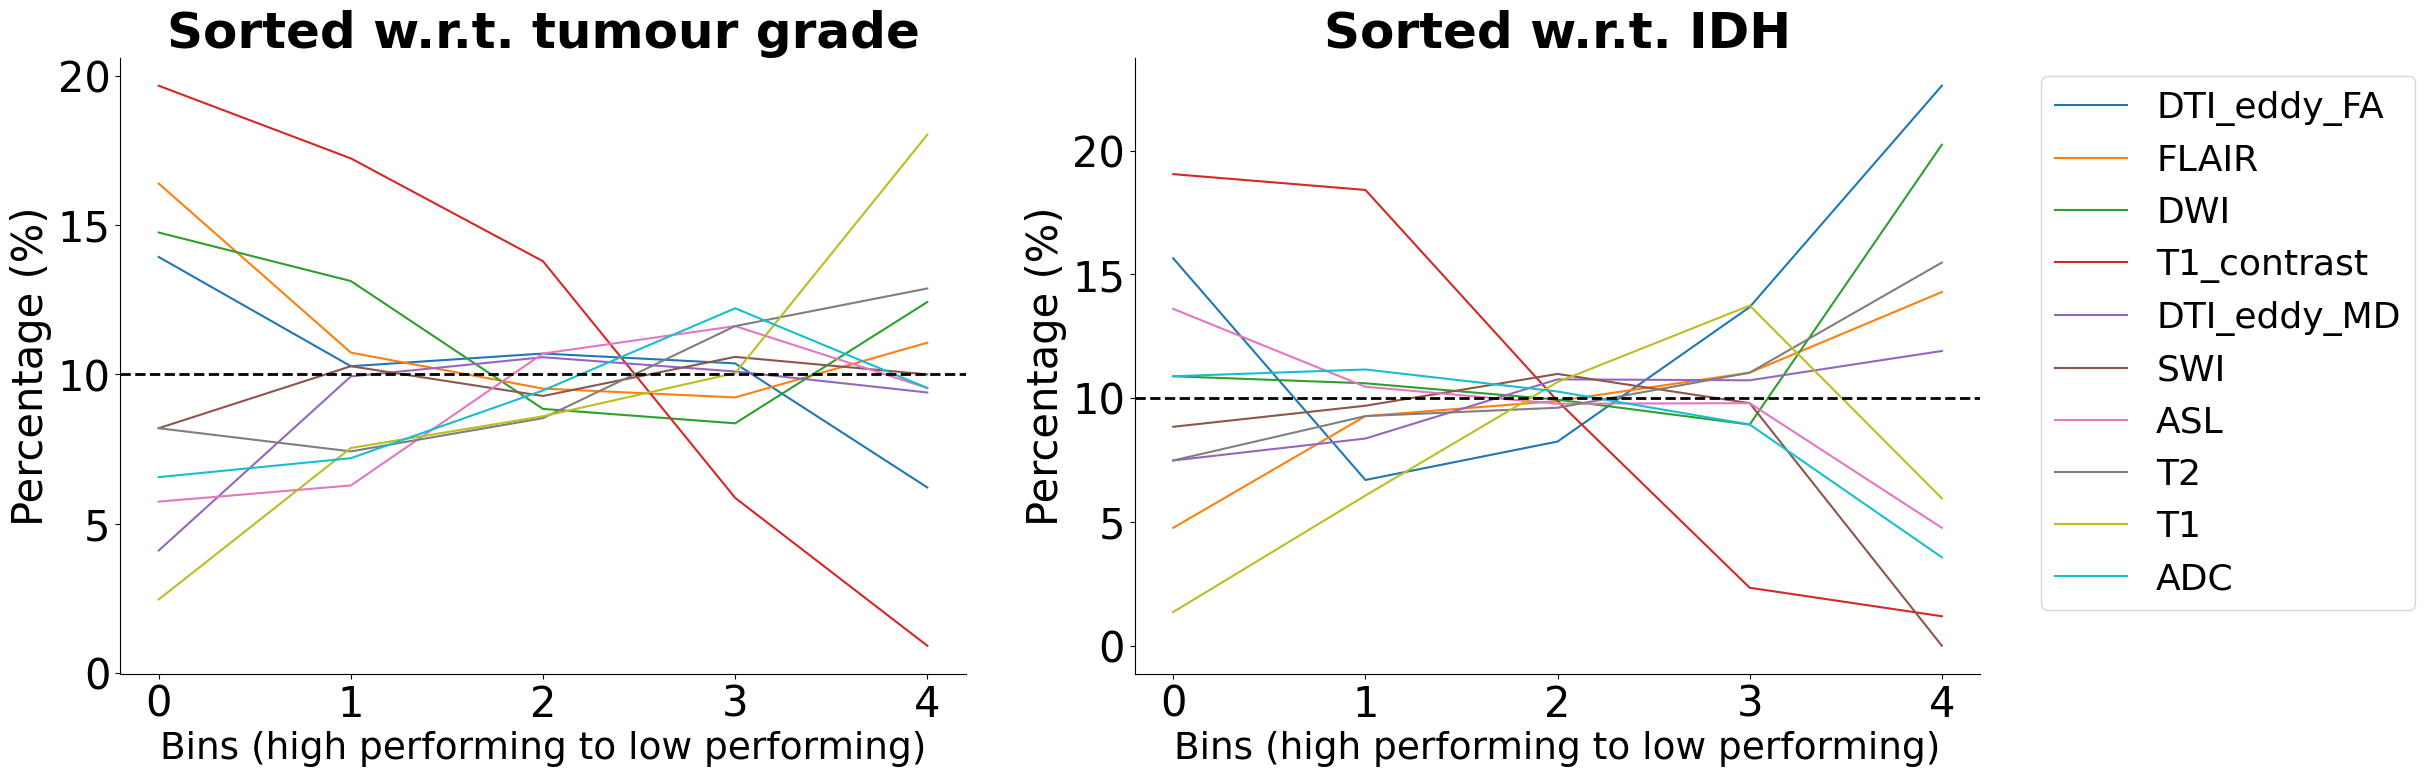

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast
from matplotlib.ticker import MultipleLocator

# Define the number of bins and font size
num_bins = 5
fontsize = 30

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Sort dataframes
df_sorted_WHO = df_sorted_all.sort_values(by="WHO CNS Grade balanced-accuracy")
df_sorted_IDH = df_sorted_all.sort_values(by="IDH balanced-accuracy")

# Define your own bin edges based on the data range
bin_edges_WHO = np.linspace(df_sorted_WHO['WHO CNS Grade balanced-accuracy'].min(), df_sorted_WHO['WHO CNS Grade balanced-accuracy'].max(), num_bins + 1)
bin_edges_IDH = np.linspace(df_sorted_IDH['IDH balanced-accuracy'].min(), df_sorted_IDH['IDH balanced-accuracy'].max(), num_bins + 1)

df_sorted_WHO['bin'] = pd.cut(df_sorted_WHO['WHO CNS Grade balanced-accuracy'], bins=bin_edges_WHO, labels=False)
df_sorted_IDH['bin'] = pd.cut(df_sorted_IDH['IDH balanced-accuracy'], bins=bin_edges_IDH, labels=False)

# All modalities
all_modalities = ['DTI_eddy_FA', 'FLAIR', 'DWI', 'T1_contrast', 'DTI_eddy_MD', 'SWI', 'ASL', 'T2', 'T1', 'ADC']

# Loop to generate plots for both subplots
for idx, (df_sorted, ax) in enumerate([(df_sorted_WHO, axs[0]), (df_sorted_IDH, axs[1])]):
    
    # Initialize results dictionary
    results = {}

    # Iterate over each bin
    for bin_num in range(num_bins):
        bin_rows = df_sorted[df_sorted['bin'] == bin_num]
        all_acquisitions = [acquisition for sublist in bin_rows['Acquisition'].apply(ast.literal_eval) for acquisition in sublist]
        counter = Counter(all_acquisitions)
        results[bin_num] = counter
    
    # Initialize modality_counts
    modality_counts = {modality: [] for modality in all_modalities}

    # Populate counts
    for bin_num in range(num_bins-1, -1, -1):
        if len(results[bin_num]) == 0:
            continue
        total_acquisitions = sum(results[bin_num].values())
        for modality in all_modalities:
            modality_counts[modality].append((results[bin_num][modality] / total_acquisitions) * 100)
    
    # Plotting
    for modality, counts in modality_counts.items():
        ax.plot(range(len(counts)), counts, label=modality)

    ax.set_xlabel('Bins (high performing to low performing)', fontsize=fontsize-3)
    ax.set_ylabel('Percentage (%)', fontsize=fontsize)
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("Sorted w.r.t. tumour grade" if idx == 0 else "Sorted w.r.t. IDH", fontweight='bold')
    if idx == 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=fontsize - 4)
    ax.axhline(10, color='black', linestyle='--', linewidth=2)





# Set global font size
plt.rcParams.update({'font.size': fontsize})

# Save and display the figure
plt.savefig('/Users/Gabriel/Desktop/modalities_importance.png', dpi=300, bbox_inches='tight')
plt.show()


## Average performance if Modality present

In [87]:
# List of all modalities
all_modalities = ['DTI_eddy_FA', 'FLAIR', 'DWI', 'T1_contrast', 'DTI_eddy_MD', 'SWI', 'ASL', 'T2']

# Initialize dictionaries to hold totals and counts for each modality
modality_totals = {modality: 0 for modality in all_modalities}
modality_counts = {modality: 0 for modality in all_modalities}

# Iterate over each row of the DataFrame
for index, row in df_sorted_all.iterrows():
    # Convert string to tuple
    acquisitions = ast.literal_eval(row['Acquisition'])
    
    # For each modality
    for modality in all_modalities:
        # If modality is present in the acquisitions
        if modality in acquisitions:
            # Add the sum to the total and increment the count
            modality_totals[modality] += row['sum']
            modality_counts[modality] += 1

# Calculate the average performance for each modality
modality_averages = {modality: total / count if count > 0 else 0 
                     for modality, total, count in zip(modality_totals.keys(), 
                                                       modality_totals.values(), 
                                                       modality_counts.values())}

# Sort modality_averages dictionary by values in descending order
sorted_averages = dict(sorted(modality_averages.items(), key=lambda item: item[1], reverse=True))

# Print each modality and its average, rounded to two decimal places
for modality, average in sorted_averages.items():
    print(f"{modality}: {average:.2f}")

T1_contrast: 0.75
DWI: 0.72
SWI: 0.71
FLAIR: 0.71
ASL: 0.71
DTI_eddy_MD: 0.71
DTI_eddy_FA: 0.71
T2: 0.71
